In [1]:
import numpy as np
from tslearn.preprocessing import *
from tslearn import metrics
import matplotlib.pyplot as plt
import pandas as pd
plt.style.use('seaborn-darkgrid')
%matplotlib inline

#### 生成模拟数据
输出数据包括：
1. 原始leveling数据
2. 一定概率deletion的leveling数据/及deletion位置
3. 模拟原始电流数据

In [2]:
def simu_gen(n:int=60, rg:list=[30, 100], v:list=[100, 50], vl:list=[500, 200],pl=0.8 , cn=[0, 10], p:float=0.1, seed=123, sn=[]):
    np.random.seed(seed)
    c_a = np.random.uniform(rg[0], rg[1], n)
    if sn:
        c_b = c_a + np.random.uniform(sn[0], sn[1], n)
        ref = np.array([ i * 1 for i in c_b for j in range(0, v[0])])
    else:
        ref = np.array([ i * 1 for i in c_a for j in range(0, v[0])])
    #debug testing
    c_raw = []
    dlt = []
    for idx, i in enumerate(c_a):
        if np.random.binomial(1, 1-p):
            c_raw = c_raw + [i]
        else:
            dlt = dlt + [idx]
    v_a = np.array([np.random.normal(v[0], v[1]) if np.random.binomial(1, pl) else np.random.normal(vl[0], vl[1]) for i in range(len(c_raw))])
    level = []
    level_norm = []
    for i in zip(c_raw, v_a):
        level = level + [i[0]] * int(i[1])
        level_norm = level_norm + [i[0]]*v[0]
    level = np.array(level)
    level_norm = np.array(level_norm)
    raw = np.array([i + np.random.normal(cn[0], cn[1]) for i in level])
    return [ref, level, raw, dlt, level_norm, c_raw, c_b if sn else c_a]

In [3]:
n = 60
deletion_rate = 0.15
sn = [-5, 5]

In [4]:
s = simu_gen(n=n, cn=[0, 3], p=deletion_rate, sn=sn)

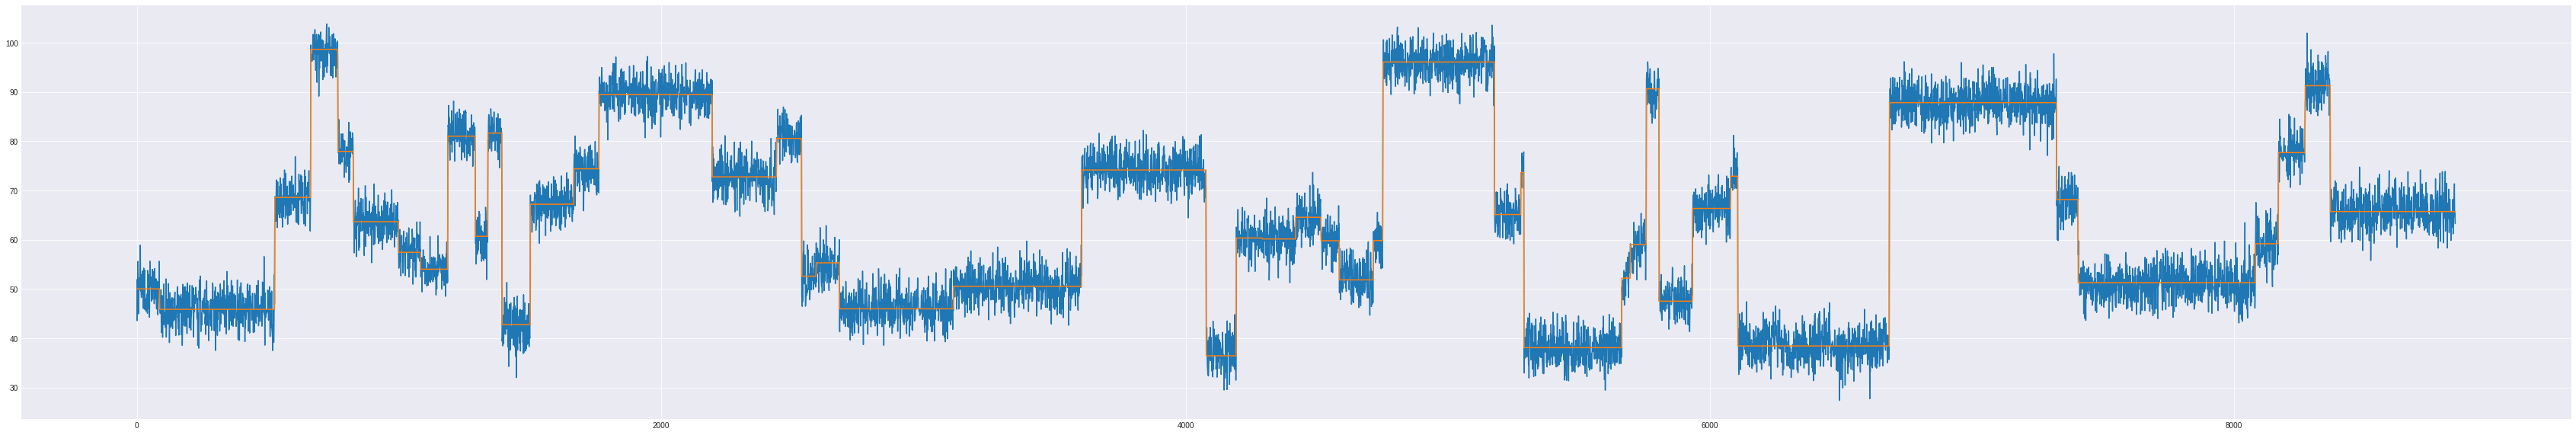

In [9]:
plt.figure(figsize=(60,10))
plt.plot(s[2])
plt.plot(s[1]);

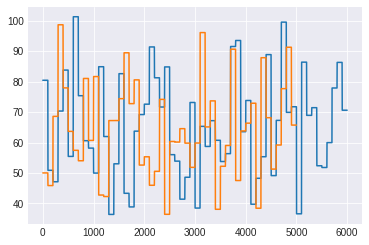

In [10]:
plt.plot(s[0]);
plt.plot(s[4])

In [45]:
s[0] = TimeSeriesScalerMinMax(min=0, max=10).fit_transform(s[0])[0].T[0]
s[4] = TimeSeriesScalerMinMax(min=0, max=10).fit_transform(s[4])[0].T[0]

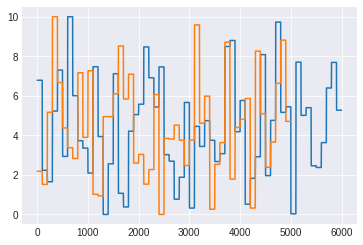

In [47]:
plt.plot(s[0]);
plt.plot(s[4]);

IndexError: index 2095 is out of bounds for axis 0 with size 2000

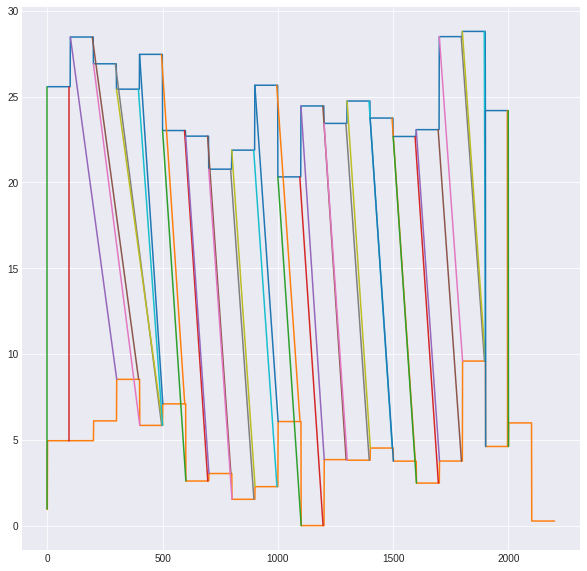

In [48]:
s_1 = s[0][2000:4000]; s_2 = s[4][1299:3500]

path, sim = metrics.dtw_path(s_1, s_2, global_constraint='sakoe_chiba_radius')

matrix_path = numpy.zeros((len(s_1), len(s_2)), dtype=numpy.int)
for i, j in path:
    matrix_path[i, j] = 1

plt.figure(figsize=(10, 10))
st = s_1 + 20
plt.plot(st)
plt.plot(s_2)
rag = np.linspace(0,6000,61)
pos = []
for i in rag:
    if i + 95 < 5999:
        pos = pos + [i, i + 95]
    else:
        pos = pos + [i, 5999]
for i in pos:
    if i != len(matrix_path):
        #print(i, matrix_path[int(i)].argmax())
        idx = int(matrix_path[int(i)].argmax())
        plt.plot([i, idx], [st[int(i)],s_2[idx]])
    else:
        i = i -1
        idx = int(matrix_path[int(i)].argmax())
        plt.plot([i, idx], [st[int(i)],s_2[idx]])
        
plt.figure(figsize=(10,10))
st = s_1 + 100
plt.plot(st)
plt.plot(s_2)
pos = []
for i in s[3]:
    pos = pos + [i*100, i*100 + 95]
for i in pos:
    if i != len(matrix_path):
        #print(i, matrix_path[int(i)].argmax())
        idx = int(matrix_path[int(i)].argmax())
        plt.plot([i, idx], [st[int(i)],s_2[idx]])
    else:
        i = i - 1
        idx = int(matrix_path[int(i)].argmax())
        plt.plot([i, idx], [st[int(i)],s_2[idx]])
        
        
deletion = []
for idx, i in enumerate(np.linspace(0,n*100,n+1)[:n]):
    i = int(i)
    if abs(matrix_path[i+99].argmax() - matrix_path[i].argmax()) < 20:
        deletion = deletion + [idx]
        
plt.figure(figsize=(10, 10))
st = s_1 + 100
plt.plot(st)
plt.plot(s_2)
pos1 = []
for i in deletion:
    if i*100 + 95 > 5999:
        pos1 = pos1 + [i*100, 5999]
    else:
        pos1 = pos1 + [i*100, i*100 + 95]
for i in pos1:
    if i < len(matrix_path):
        #print(i, matrix_path[int(i)].argmax())
        idx = int(matrix_path[int(i)].argmax())
        plt.plot([i, idx], [st[int(i)],s_2[idx]])
    else:
        i = i - 1
        idx = int(matrix_path[int(i)].argmax())
        plt.plot([i, idx], [st[int(i)],s_2[idx]])
        
print('real deletions are     %s'%(s[3]))
print('analysed deletions are %s'%(deletion))
inter = set(s[3]).intersection(set(deletion))
print('TP are                 %s'%(sorted(list(inter))))
print('DR is %s'%(len(inter)/len(s[3])))

In [33]:
sb = metrics.dtw_subsequence_path(s[0][2000:4000],s[4])

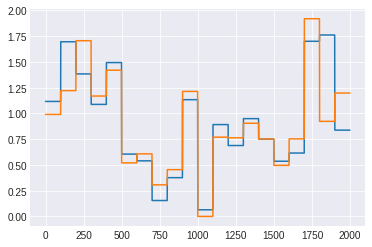

In [44]:
plt.plot(s[0][2000:4000]);
plt.plot(s[4][1400:3400])

real deletions are     [0, 4, 5, 8, 13, 14, 22, 29, 37, 45, 47, 52, 53, 54]
analysed deletions are [0, 4, 8, 13, 14, 22, 27, 29, 31, 33, 37, 42, 45, 48, 49, 52, 53, 54, 55]
TP are                 [0, 4, 8, 13, 14, 22, 29, 37, 45, 52, 53, 54]


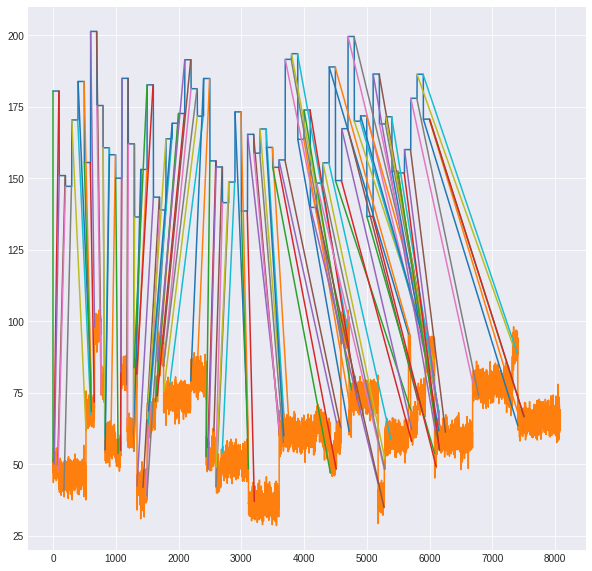

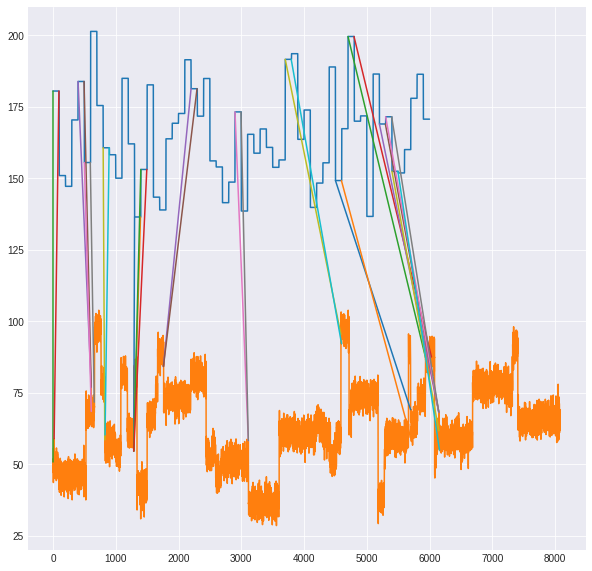

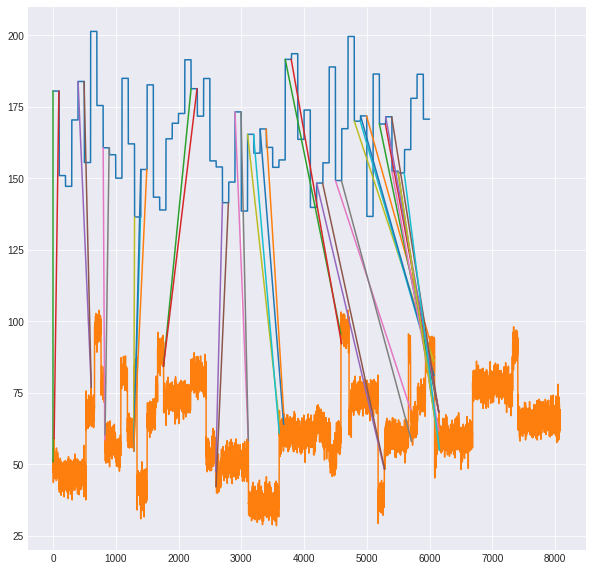

In [26]:
s_1 = s[0]; s_2 = s[2]

path, sim = metrics.dtw_path(s_1, s_2)

matrix_path = numpy.zeros((len(s_1), len(s_2)), dtype=numpy.int)
for i, j in path:
    matrix_path[i, j] = 1
    
plt.figure(figsize=(10, 10))
st = s_1 + 100
plt.plot(st)
plt.plot(s_2)
rag = np.linspace(0,6000,61)
pos = []
for i in rag:
    if i + 95 < 5999:
        pos = pos + [i, i + 95]
    else:
        pos = pos + [i, 5999]
for i in pos:
    if i != len(matrix_path):
        #print(i, matrix_path[int(i)].argmax())
        idx = int(matrix_path[int(i)].argmax())
        plt.plot([i, idx], [st[int(i)],s_2[idx]])
    else:
        i = i -1
        idx = int(matrix_path[int(i)].argmax())
        plt.plot([i, idx], [st[int(i)],s_2[idx]])
        
plt.figure(figsize=(10,10))
st = s_1 + 100
plt.plot(st)
plt.plot(s_2)
pos = []
for i in s[3]:
    pos = pos + [i*100, i*100 + 95]
for i in pos:
    if i != len(matrix_path):
        #print(i, matrix_path[int(i)].argmax())
        idx = int(matrix_path[int(i)].argmax())
        plt.plot([i, idx], [st[int(i)],s_2[idx]])
    else:
        i = i - 1
        idx = int(matrix_path[int(i)].argmax())
        plt.plot([i, idx], [st[int(i)],s_2[idx]])
        
deletion = []
for idx, i in enumerate(np.linspace(0,6000,61)[:n]):
    i = int(i)
    if abs(matrix_path[i+99].argmax() - matrix_path[i].argmax()) < 20:
        deletion = deletion + [idx]
        
plt.figure(figsize=(10, 10))
st = s_1 + 100
plt.plot(st)
plt.plot(s_2)
pos1 = []
for i in deletion:
    if i*100 + 95 > 5999:
        pos1 = pos1 + [i*100, 5999]
    else:
        pos1 = pos1 + [i*100, i*100 + 95]
for i in pos1:
    if i < len(matrix_path):
        #print(i, matrix_path[int(i)].argmax())
        idx = int(matrix_path[int(i)].argmax())
        plt.plot([i, idx], [st[int(i)],s_2[idx]])
    else:
        i = i - 1
        idx = int(matrix_path[int(i)].argmax())
        plt.plot([i, idx], [st[int(i)],s_2[idx]])
        
print('real deletions are     %s'%(s[3]))
print('analysed deletions are %s'%(deletion))
inter = set(s[3]).intersection(set(deletion))
print('TP are                 %s'%(sorted(list(inter))))

In [15]:
print('real deletions are     %s'%(s[3]))
print('analysed deletions are %s'%(deletion))
print('TP are                 %s'%(set(s[3]).intersection(set(deletion))))

real deletions are     [0, 4, 5, 8, 13, 14, 22, 29, 37, 45, 47, 52, 53, 54]
analysed deletions are [0, 4, 8, 13, 14, 22, 27, 29, 31, 33, 37, 42, 45, 48, 49, 52, 53, 54, 55]
TP are                 {0, 4, 37, 8, 13, 14, 45, 52, 53, 22, 54, 29}


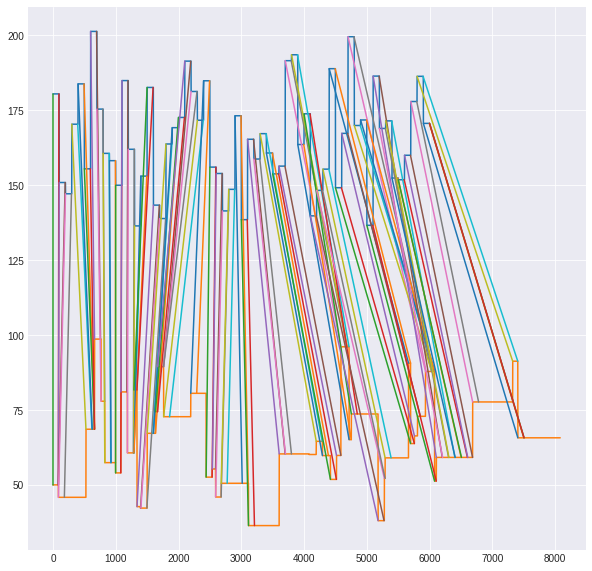

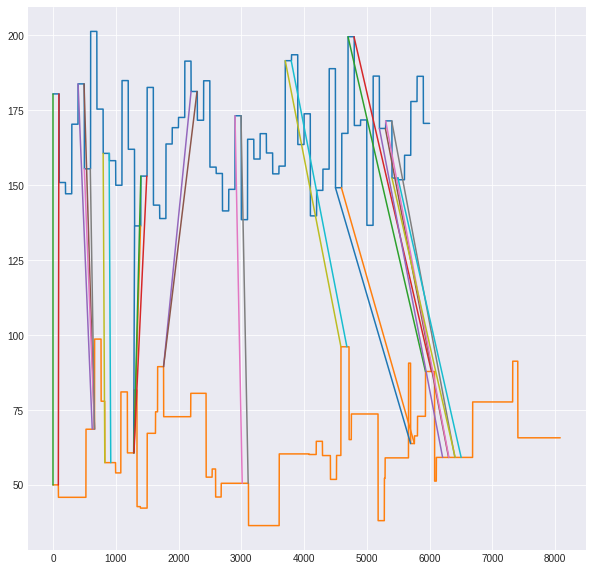

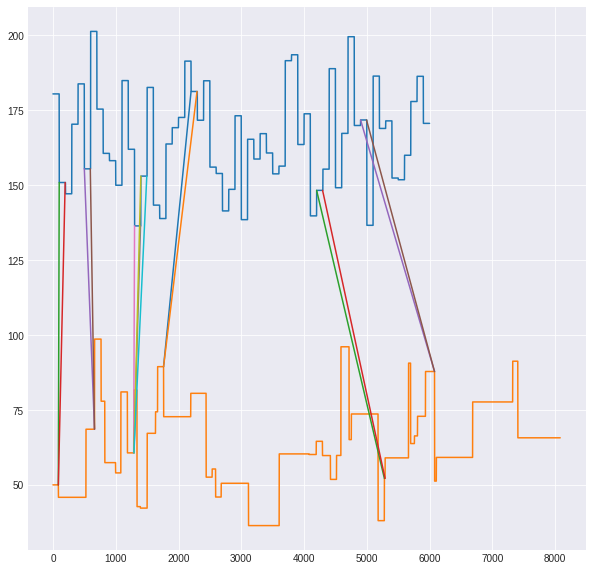

In [16]:
s_1 = s[0]; s_2 = s[1]

path, sim = metrics.dtw_path(s_1, s_2)

matrix_path = numpy.zeros((len(s_1), len(s_2)), dtype=numpy.int)
for i, j in path:
    matrix_path[i, j] = 1
    
plt.figure(figsize=(10, 10))
st = s_1 + 100
plt.plot(st)
plt.plot(s_2)
rag = np.linspace(0,6000,61)
pos = []
for i in rag:
    if i + 95 < 5999:
        pos = pos + [i, i + 95]
    else:
        pos = pos + [i, 5999]
for i in pos:
    if i != len(matrix_path):
        #print(i, matrix_path[int(i)].argmax())
        idx = int(matrix_path[int(i)].argmax())
        plt.plot([i, idx], [st[int(i)],s_2[idx]])
    else:
        i = i -1
        idx = int(matrix_path[int(i)].argmax())
        plt.plot([i, idx], [st[int(i)],s_2[idx]])
        
plt.figure(figsize=(10,10))
st = s_1 + 100
plt.plot(st)
plt.plot(s_2)
pos = []
for i in s[3]:
    pos = pos + [i*100, i*100 + 95]
for i in pos:
    if i != len(matrix_path):
        #print(i, matrix_path[int(i)].argmax())
        idx = int(matrix_path[int(i)].argmax())
        plt.plot([i, idx], [st[int(i)],s_2[idx]])
    else:
        i = i - 1
        idx = int(matrix_path[int(i)].argmax())
        plt.plot([i, idx], [st[int(i)],s_2[idx]])
        
deletion = []
for idx, i in enumerate(np.linspace(0,6000,61)[:n]):
    i = int(i)
    if abs(matrix_path[i+99].argmax() - matrix_path[i].argmax()) < 20:
        deletion = deletion + [idx]
        
plt.figure(figsize=(10, 10))
st = s_1 + 100
plt.plot(st)
plt.plot(s_2)
pos1 = []
for i in deletion:
    if i*100 + 95 > 5999:
        pos1 = pos1 + [i*100, 5999]
    else:
        pos1 = pos1 + [i*100, i*100 + 95]
for i in pos1:
    if i < len(matrix_path):
        #print(i, matrix_path[int(i)].argmax())
        idx = int(matrix_path[int(i)].argmax())
        plt.plot([i, idx], [st[int(i)],s_2[idx]])
    else:
        i = i - 1
        idx = int(matrix_path[int(i)].argmax())
        plt.plot([i, idx], [st[int(i)],s_2[idx]])

In [25]:
print('real deletions are     %s'%(s[3]))
print('analysed deletions are %s'%(deletion))
inter = set(s[3]).intersection(set(deletion))
print('TP are                 %s'%(sorted(list(inter))))

real deletions are     [0, 4, 5, 8, 13, 14, 22, 29, 37, 45, 47, 52, 53, 54]
analysed deletions are [1, 5, 13, 14, 22, 42, 49]
TP are                 [5, 13, 14, 22]


In [38]:

import itertools
def ldtw(a,b):
    D = np.zeros((len(a) + 1, len(b) + 1))
    D[0, 1:] = np.inf
    D[1:, 0] = np.inf
    d = lambda x, y: np.abs(x - y)
    for i, j in itertools.product(range(1, D.shape[0]), range(1, D.shape[1])):
        m = D[i-1, j-1]
        m1 = D[i-2,j-1]+d(i-1,j)+1/3
        m2 = D[i-1,j-2]+d(i,j-1)+1/3
        m3 = D[i-3,j-1]+d(i-2,j)+d(i-1,j)+2/3
        m4 = D[i-1,j-3]+d(i,j-2)+d(i,j-1)+2/3
        D[i, j] = d(i, j) + min(m, m1, m2, m3, m4)
    return D

def traceback(H, t=[], old_i=0):
    # flip H to get index of **last** occurrence of H.max() with np.argmax()
    H_flip = np.flip(np.flip(H, 0), 1)
    i_, j_ = np.unravel_index(H_flip.argmin(), H_flip.shape)
    i, j = np.subtract(H.shape, (i_ + 1, j_ + 1))  # (i, j) are **last** indexes of H.max()
    if i == 0 or j == 0:
        return t
    t = t + [(i, j)]
    return traceback(H[0:i, 0:j], t, i)
D = ldtw([0, 4, 5, 8, 13, 14, 22, 29, 37, 45, 47, 52, 53, 54], [1, 5, 13, 14, 22, 42, 49])
traceback(D)  
print(D)

[[ 0.                 inf         inf         inf         inf         inf
          inf         inf]
 [        inf  0.          1.33333333  3.66666667  7.33333333  9.33333333
  11.33333333 13.33333333]
 [        inf  1.33333333  0.          1.33333333  3.66666667  8.
  13.33333333 16.33333333]
 [        inf  3.66666667  1.33333333  0.          1.33333333  3.66666667
   8.         13.33333333]
 [        inf 20.66666667  3.66666667  1.33333333  0.          1.33333333
   3.66666667  8.        ]
 [        inf 17.33333333  8.          3.66666667  1.33333333  0.
   1.33333333  3.66666667]
 [        inf 15.         13.33333333  8.          3.66666667  1.33333333
   0.          1.33333333]
 [        inf 14.66666667 20.         13.33333333  8.          3.66666667
   1.33333333  0.        ]
 [        inf 15.33333333 20.66666667 20.66666667 13.33333333  8.
   3.66666667  1.33333333]
 [        inf 18.66666667 22.33333333 26.66666667 20.66666667 13.33333333
   8.          3.66666667]
 [        inf 

In [41]:
import itertools
a = [0, 4, 5, 8, 13, 14, 22, 29, 37, 45, 47, 52, 53, 54]
b = [1, 5, 13, 14, 22, 42, 49]
D = np.zeros((len(a) + 1, len(b) + 1))
D[0, 1:] = np.inf
D[1:, 0] = np.inf

In [42]:
D

array([[ 0., inf, inf, inf, inf, inf, inf, inf],
       [inf,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [inf,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [inf,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [inf,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [inf,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [inf,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [inf,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [inf,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [inf,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [inf,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [inf,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [inf,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [inf,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [inf,  0.,  0.,  0.,  0.,  0.,  0.,  0.]])

In [25]:
D[1,1]

inf